In [73]:
import os
import sys
from pathlib import Path

# Add source directory to system path
source_dir = str(Path(os.getcwd()).parent / 'src')
sys.path.append(source_dir)

Label: 7


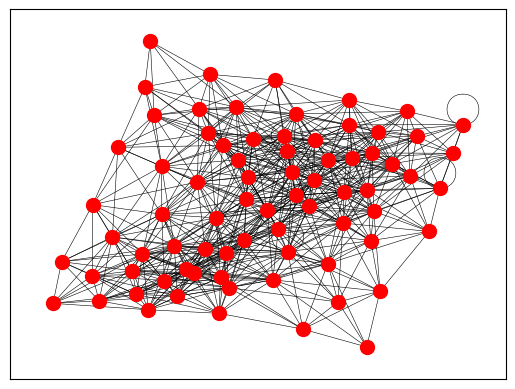

In [74]:
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.utils import to_networkx
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import os
import numpy as np

root = str(Path(os.getcwd()).parent / 'data' / 'mnist-superpixels')
dataset = MNISTSuperpixels(root=root)
sample = dataset[int(np.random.sample()*len(dataset))]
print("Label: {}".format(sample.y[0].cpu().numpy()))
G = to_networkx(sample, to_undirected=True)
nx.draw_networkx(G, with_labels=False, node_size=100, node_color="red", width=0.4)

In [75]:
from models import GNN
model = GNN(dataset.num_features, 512, dataset.num_classes, numLayers=2, dropout=0.2)
print("Number of Model Parameters: {}".format(sum(p.numel() for p in model.parameters())))
print(model)

Number of Model Parameters: 795146
GNN(
  (convs): ModuleList(
    (0): GraphSage(1, 512)
    (1): GraphSage(512, 512)
  )
  (postMP): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
  (logSoftmax): LogSoftmax(dim=1)
)


In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from tqdm import tqdm


# Training Parameters
num_epochs = 500
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# dataset = dataset[: int(len(dataset) * 0.5)]   # comment out if using full dataset
train_split, valid_split, test_split = 0.8, 0.1, 0.1
train_size = int(len(dataset) * train_split)
valid_size = int(len(dataset) * valid_split)
test_size = int(len(dataset) * test_split)

# Hyperparameters
learning_rate = 0.0001

# Data Loader
batch_size = 64
train_loader = DataLoader(dataset[: train_size], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset[train_size: train_size + valid_size], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset[train_size + valid_size:], batch_size=batch_size, shuffle=True)

# Loss Function and Optimizer
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train
losses = []
train_accs = []
test_accs = []
best_acc = 0
best_model = None

for epoch in range(num_epochs):
  total_loss = 0
  total_acc = 0.0
  model.train()
  for data in tqdm(train_loader):
    data.to(device)
    optimizer.zero_grad()
    pred = model(data)
    # pred = pred[data.train_mask]
    label = data.y
    # label = label[data.train_mask]
    loss = loss_func(pred, label)
    loss.backward()
    optimizer.step()
    total_loss += loss.item() * data.num_graphs
    total_acc += torch.sum(torch.where(torch.argmax(pred, dim=1) == label, 1, 0))
  total_loss /= len(train_loader.dataset)
  total_acc /= len(train_loader.dataset)
  losses.append(total_loss)

  model.eval()
  valid_acc = 0.0
  for data in valid_loader:
    with torch.no_grad():
      data.to(device)
      pred = model(data)
      label = data.y
      valid_acc += torch.sum(torch.where(torch.argmax(pred, dim=1) == label, 1, 0))
  valid_acc /= len(valid_loader.dataset)

  print("Epoch {} | Training Loss: {:.5f} | Train Acc.: {:.4f} | Valid Acc.: {:.4f}".format(epoch, losses[-1], total_acc, valid_acc))

100%|██████████| 750/750 [00:12<00:00, 59.09it/s]


Epoch 0 | Training Loss: 2.27990 | Train Acc.: 0.1338 | Valid Acc.: 0.2348


 57%|█████▋    | 425/750 [00:06<00:05, 63.47it/s]


KeyboardInterrupt: 